# In this notebook, we analyze the spectra data

## 0. Download the data
* Find SDSS J000605.59-092007.0 (00:06:05.59, -09:20:07.0) in SDSS database
  * Check our previous material if you forget how to do it :)
* Download the spectrum (`spec-0651-52141-0434.fits`)
* Please download the tables of the AGN sample from Liu et al. (2019) and galaxies from Kormendy & Ho (2013) in the `tabs` folder of the [PKU disk](https://disk.pku.edu.cn/link/AA62A41DA825EB43B6BF933F7E8EED52AE) (pw: obsexp).

## 1. Plot the spectrum and prepare for the fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d

import matplotlib as mpl

mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

Flux units: 1E-17 erg/cm^2/s/Ang


/var/folders/x7/ww3bm0kx1mq7v6r3dk8mccw80000gn/T/ipykernel_9761/3545489729.py:8: RuntimeWarning: divide by zero encountered in divide
  ferr_obs = np.sqrt(1/ivar_obs)  # Flux error


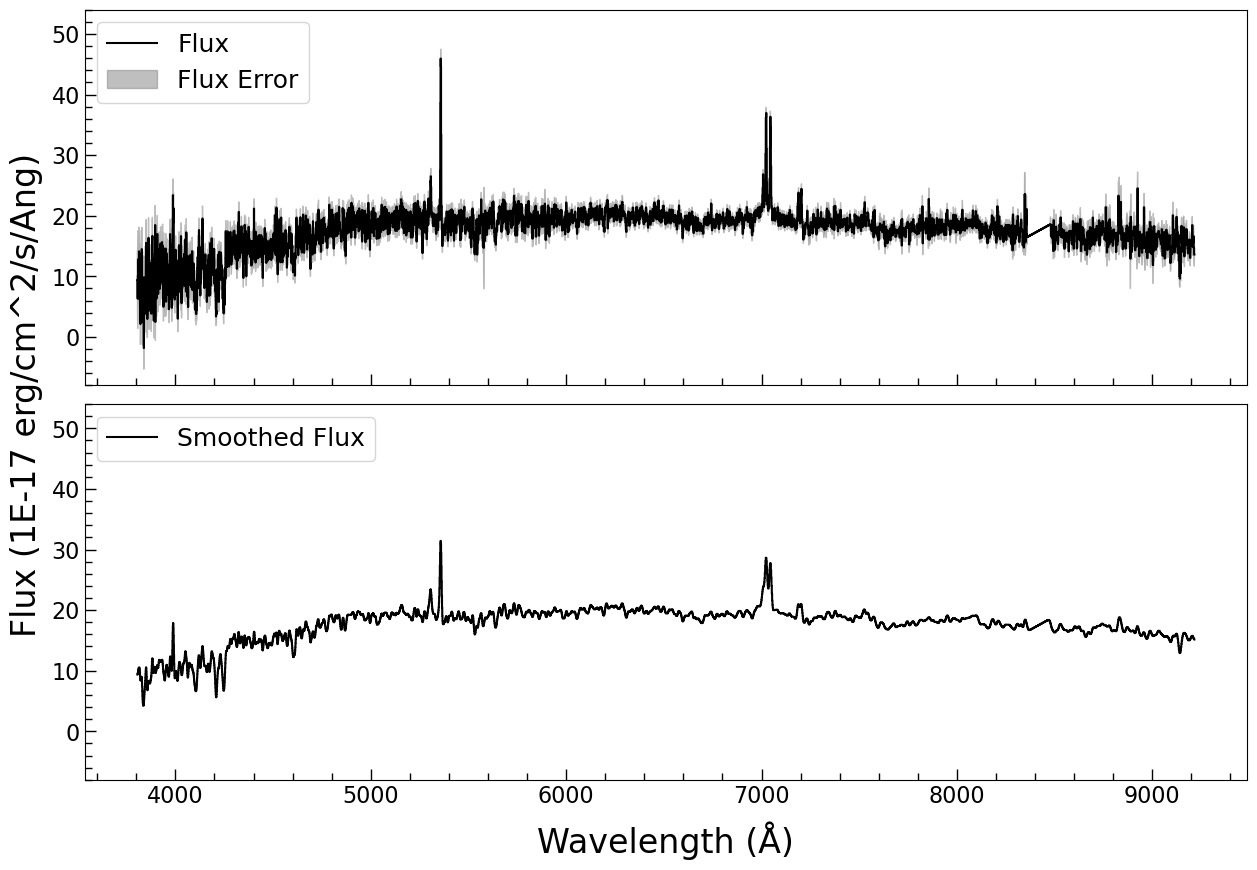

In [2]:
# Read the data and plot

hdul = fits.open('data/sdss-spec/spec-0651-52141-0434.fits')
flux_obs = hdul[1].data['flux'].astype(float)
loglam = hdul[1].data['loglam'].astype(float)
wave_obs = 10**loglam  # Convert log wavelength to linear scale
ivar_obs = hdul[1].data['ivar'].astype(float)  # Inverse variance
ferr_obs = np.sqrt(1/ivar_obs)  # Flux error

units = hdul[0].header['BUNIT']
print(f"Flux units: {units}")

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05)
axo = fig.add_subplot(111, frameon=False) # The out axis
axo.tick_params(axis='y', which='both', left=False, labelleft=False)
axo.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axo.set_xlabel(r'Wavelength (Å)', fontsize=24, labelpad=30)
axo.set_ylabel(f'Flux ({units})', fontsize=24, labelpad=30)

ax = axs[0]
ax.step(wave_obs, flux_obs, where='mid', color='k', label='Flux')
ax.fill_between(wave_obs, flux_obs - ferr_obs, flux_obs + ferr_obs, color='gray', alpha=0.5, label='Flux Error')
ax.minorticks_on()
ax.legend(loc='upper left', fontsize=18)
ax.set_ylim(-8, 54)

ax = axs[1]
flux_smooth = gaussian_filter1d(flux_obs, sigma=3)
ax.step(wave_obs, flux_smooth, where='mid', color='k', label='Smoothed Flux')
ax.legend(loc='upper left', fontsize=18)
plt.show()

### Correct the reddening and convert the wavelength to the rest frame
* Check the $A_V$ and redshift of the source from [NED](https://ned.ipac.caltech.edu/)
* You may need to install the [extinction](https://extinction.readthedocs.io/) package to correct the Galactic reddening

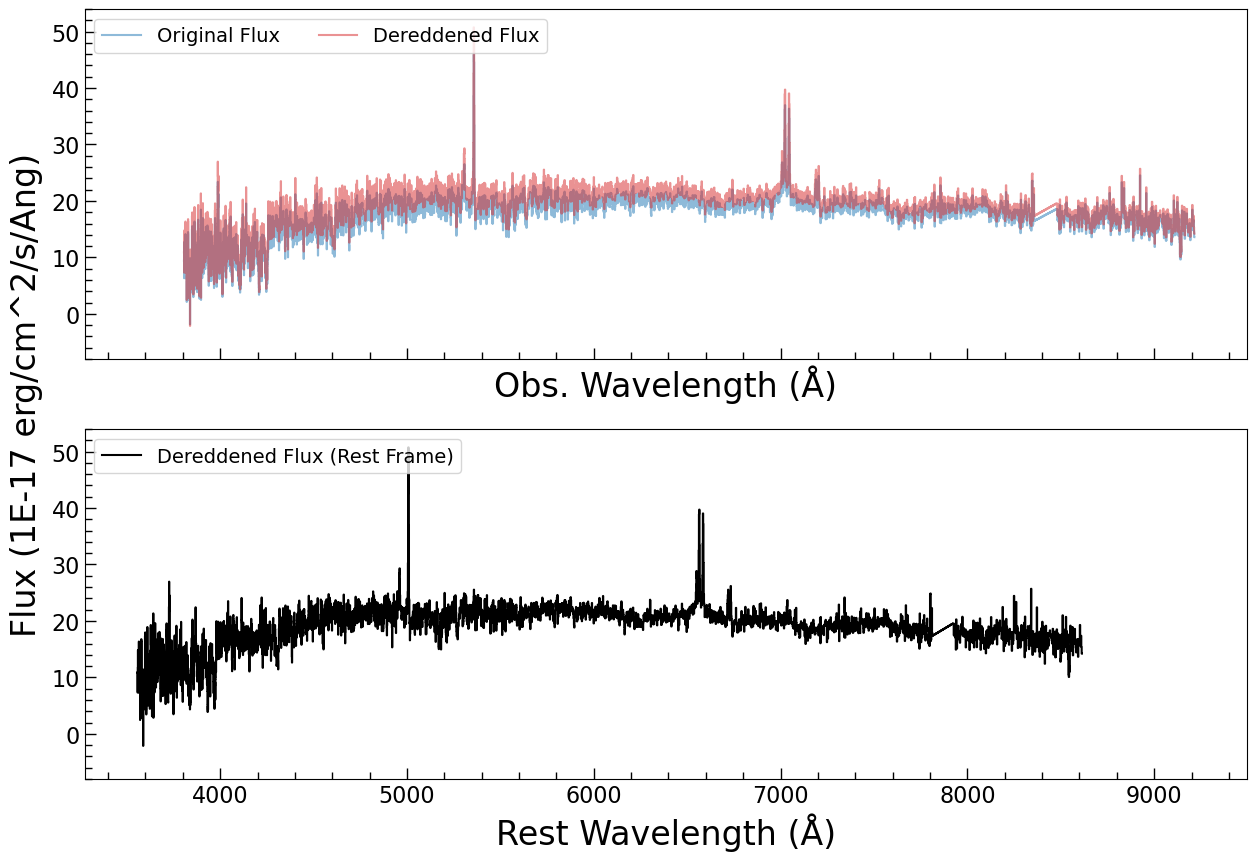

In [3]:
import extinction

zred = 0.069907
A_v = 0.105

A_lambda = extinction.ccm89(wave_obs, A_v, r_v=3.1)
wave_rest = wave_obs / (1 + zred)
flux_dered = flux_obs * 10**(0.4 * A_lambda)
ferr_dered = ferr_obs * 10**(0.4 * A_lambda)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
axo = fig.add_subplot(111, frameon=False) # The out axis
axo.tick_params(axis='y', which='both', left=False, labelleft=False)
axo.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axo.set_ylabel(f'Flux ({units})', fontsize=24, labelpad=30)

ax = axs[0]
ax.step(wave_obs, flux_obs, where='mid', color='C0', alpha=0.5, label='Original Flux')
ax.step(wave_obs, flux_dered, where='mid', color='C3', alpha=0.5, label='Dereddened Flux')
ax.minorticks_on()
ax.set_xlabel(r'Obs. Wavelength (Å)', fontsize=24)
ax.set_ylim(-8, 54)
ax.legend(loc='upper left', fontsize=14, ncols=3)

ax = axs[1]
ax.step(wave_rest, flux_dered, where='mid', color='k', alpha=1, label='Dereddened Flux (Rest Frame)')
ax.minorticks_on()
ax.set_xlabel(r'Rest Wavelength (Å)', fontsize=24)
ax.set_ylim(-8, 54)
ax.legend(loc='upper left', fontsize=14, ncols=3)
plt.show()

## Fit the continnum
* Measure the velocity dispersion of the host galaxy and the 5100Å monochromatic flux of the accretion disk

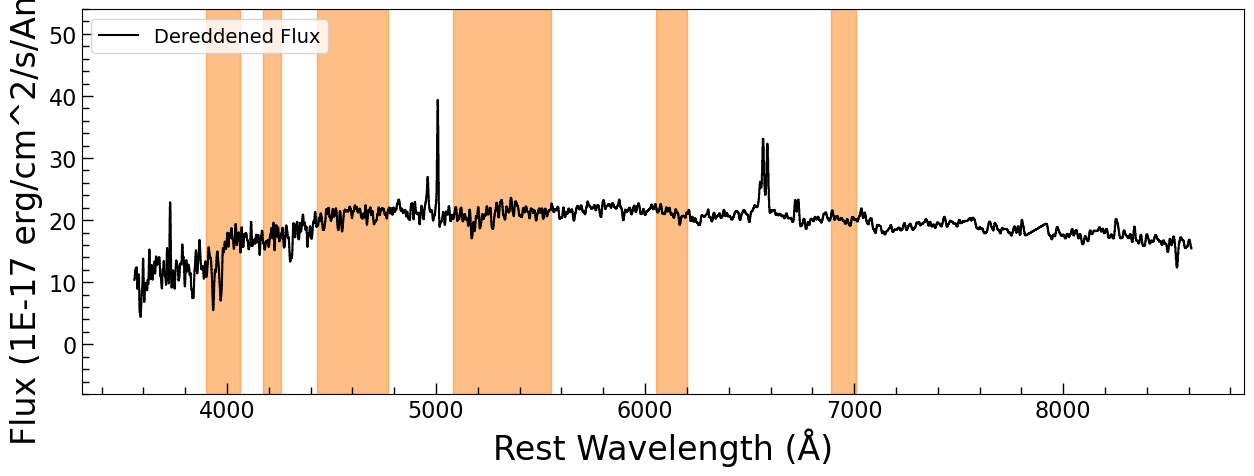

In [4]:
# From Greene & Ho (2005, ApJ, 630, 122); The first window is to include Ca II K&H.
cont_windows = [[3900, 4060], [4170, 4260], [4430, 4770], [5080, 5550], [6050, 6200], [6890, 7010]]  

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.step(wave_rest, gaussian_filter1d(flux_dered, 2), where='mid', color='k', label='Dereddened Flux')
for window in cont_windows:
    ax.axvspan(window[0], window[1], color='C1', alpha=0.5)
ax.set_xlabel(r'Rest Wavelength (Å)', fontsize=24)
ax.set_ylabel(f'Flux ({units})', fontsize=24)
ax.minorticks_on()
ax.set_ylim(-8, 54)
ax.legend(loc='upper left', fontsize=14)
plt.show()

#### Use the [SAGAN](https://github.com/jyshangguan/SAGAN) package developed by Jinyi Shangguan's team for the fitting
* Clone the package to your local directory, which Let's call `SAGANPATH`
* Include the `SAGANPATH` in your `PYTHONPATH` in order to use it

In [5]:
import sys
sys.path.append('/Users/shangguan/Softwares/my_modules/SAGAN')
import sagan
from astropy.modeling import models, fitting

/Users/shangguan/Softwares/my_modules/SAGAN/sagan/stellar_continuum.py:311: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


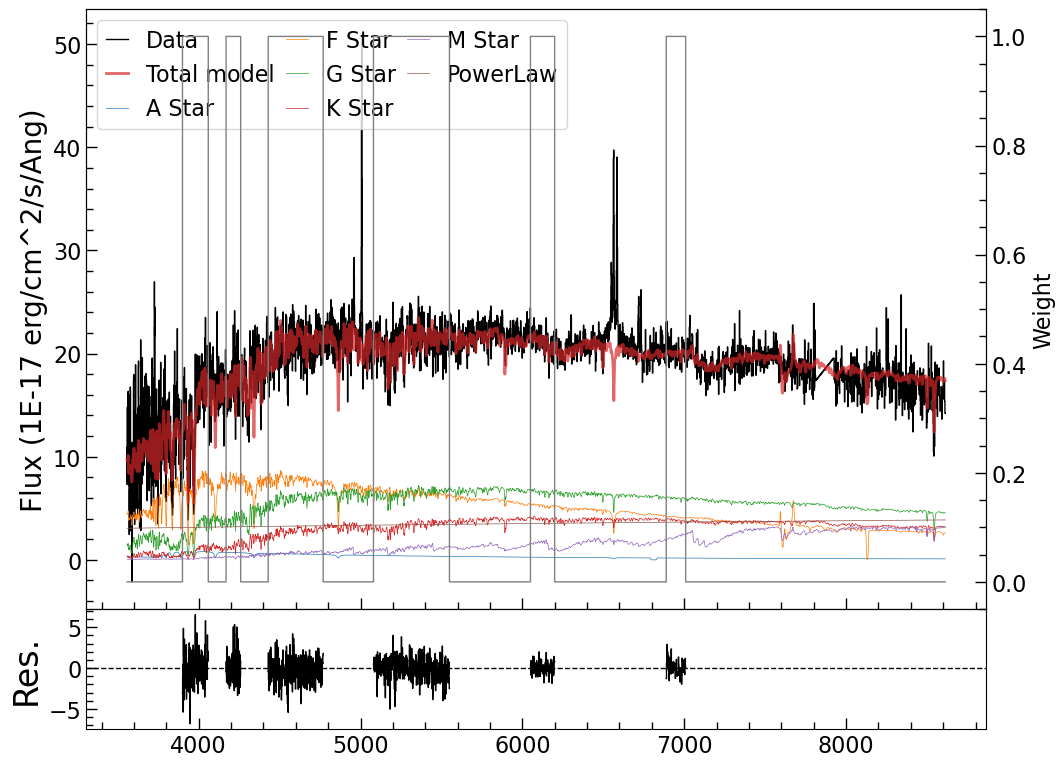

<StarSpectrum(amplitude=0.81859555, sigma=79.6233988, delta_z=-0.00031472, name='A Star')>
<StarSpectrum(amplitude=9.00841586, sigma=79.6233988, delta_z=-0.00031472, name='F Star')>
<StarSpectrum(amplitude=7.32038827, sigma=79.6233988, delta_z=-0.00031472, name='G Star')>
<StarSpectrum(amplitude=4.28797446, sigma=79.6233988, delta_z=-0.00031472, name='K Star')>
<StarSpectrum(amplitude=3.73776142, sigma=79.6233988, delta_z=-0.00031472, name='M Star')>
<PowerLaw1D(amplitude=3.35418096, x_0=5000., alpha=-0.26414091, name='PowerLaw')>


In [6]:
weights = np.zeros_like(wave_rest)
for window in cont_windows:
    weights[(wave_rest >= window[0]) & (wave_rest <= window[1])] = 1.0

# Following Kong & Ho (2018, ApJ, 865, 116)
velscale = 20
bounds = {'sigma':(velscale, 300)}
sigma = 100
delta_z = 0
Star_A = sagan.StarSpectrum(amplitude=0.81861348, sigma=79.62810518, delta_z=-0.00031473, velscale=velscale, Star_type='A', name='A Star', bounds=bounds)
Star_F = sagan.StarSpectrum(amplitude=9.00857466, sigma=79.62810518, delta_z=-0.00031473, velscale=velscale, Star_type='F', name='F Star', bounds=bounds)
Star_G = sagan.StarSpectrum(amplitude=7.32022514, sigma=79.62810518, delta_z=-0.00031473, velscale=velscale, Star_type='G', name='G Star', bounds=bounds)
Star_K = sagan.StarSpectrum(amplitude=4.28809967, sigma=79.62810518, delta_z=-0.00031473, velscale=velscale, Star_type='K', name='K Star', bounds=bounds)
Star_M = sagan.StarSpectrum(amplitude=3.73763399, sigma=79.62810518, delta_z=-0.00031473, velscale=velscale, Star_type='M', name='M Star', bounds=bounds)

stars = Star_A + Star_F + Star_G + Star_K + Star_M  #
for mn in ['A Star', 'F Star', 'G Star', 'M Star']:
    stars[mn].sigma.tied = sagan.tie_StarSpectrum_sigma('K Star')
    stars[mn].delta_z.tied = sagan.tie_StarSpectrum_deltaz('K Star')

pl = models.PowerLaw1D(amplitude=10, x_0=5000, alpha=1.7, name='PowerLaw', fixed={'x_0':True, 'alpha':False})
#iron = sagan.IronTemplate(amplitude=5, stddev=1000, z=0, name='Iron')  # Most AGN need this iron template component, but this one does not show significant iron features, so we ignore it here.
m_init = stars + pl #+ iron

fitter = fitting.LevMarLSQFitter()
m_fit = fitter(m_init, wave_rest, flux_dered, weights=weights, maxiter=10000)

ax, axr = sagan.plot_fit(wave_rest, flux_dered, m_fit, weight=weights)
ax.set_ylabel(f'Flux ({units})', fontsize=20)
plt.show()

for m in m_fit:
    print(m.__repr__())

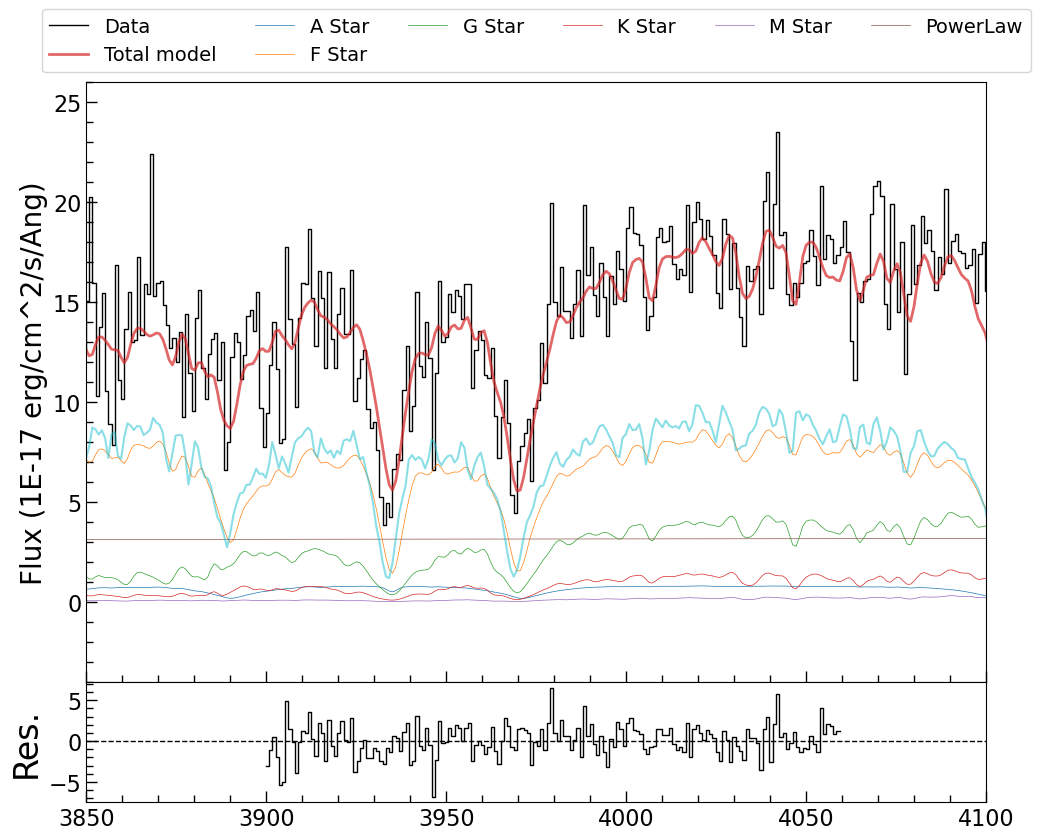

In [27]:
# Zoom in the Ca II H&K region to see the absorption line width
ax, axr = sagan.plot_fit(wave_rest, flux_dered, m_fit, weight=weights, plot_weight=False)

flux_F_norm = sagan.StarSpectrum(amplitude=10, sigma=0, delta_z=m_fit['F Star'].delta_z.value, velscale=velscale, Star_type='F')(wave_rest)
ax.plot(wave_rest, flux_F_norm, color='C9', alpha=0.5)
ax.set_xlim([3850, 4100])
ax.set_ylim([-4, 26])
ax.set_ylabel(f'Flux ({units})', fontsize=20)
ax.legend(fontsize=14, ncols=6, loc='lower center', bbox_to_anchor=(0.5, 1))
plt.show()

#### Get the emission line spectrum and the physical parameters

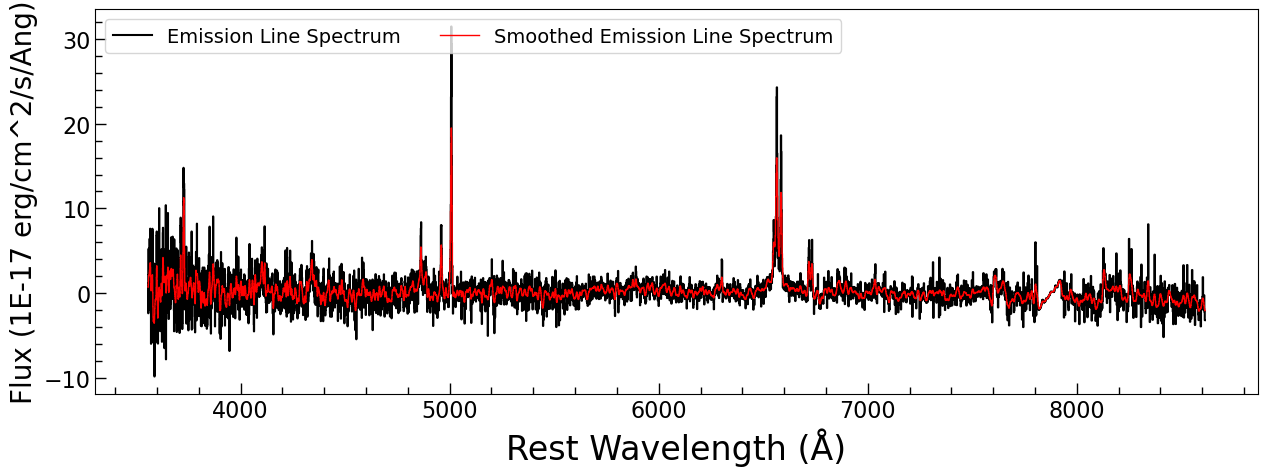


The velocity dispersion (sigma) is 79.62 km/s
The 5100 Å continuum luminosity is 2.17e+42 erg/s


In [7]:
from astropy.cosmology import Planck18 as cosmo

flux_lines = flux_dered - m_fit(wave_rest)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.step(wave_rest, flux_lines, where='mid', color='k', label='Emission Line Spectrum')
ax.step(wave_rest, gaussian_filter1d(flux_lines, 2), where='mid', lw=1, color='r', label='Smoothed Emission Line Spectrum')
ax.set_xlabel(r'Rest Wavelength (Å)', fontsize=24)
ax.set_ylabel(f'Flux ({units})', fontsize=20)
ax.minorticks_on()
ax.legend(loc='upper left', fontsize=14, ncols=2)
plt.show()

lum_dist = cosmo.luminosity_distance(zred).to('cm').value
sigma_star = m_fit['K Star'].sigma.value  # in km/s
lamFlam = m_fit['PowerLaw'].amplitude.value * 5100 * 1e-17  #erg/s/cm2
nuLnu = lamFlam * 4 * np.pi * lum_dist**2  # erg/s
print('\nThe velocity dispersion (sigma) is {:.2f} km/s'.format(sigma_star))
print('The 5100 Å continuum luminosity is {:.2e} erg/s'.format(nuLnu))

## Fit the emission lines
* We will measusre the luminosity, line width (FWHM) of H⍺, Hβ, [O III]5007,4949, [N II]6548,6583, [S II]6716,6731

In [8]:
# Load the wavelengths

line_wave_dict = sagan.line_wave_dict
wavec_ha = line_wave_dict['Halpha']
wavec_hb = line_wave_dict['Hbeta']
wavec_oiii_5007 = line_wave_dict['OIII_5007']
wavec_oiii_4959 = line_wave_dict['OIII_4959']
wavec_nii_6583 = line_wave_dict['NII_6583']
wavec_nii_6548 = line_wave_dict['NII_6548']
wavec_sii_6716 = line_wave_dict['SII_6716']
wavec_sii_6731 = line_wave_dict['SII_6731']

### First fit the narrow [S II] doublet as the narrow line templates

/Users/shangguan/Softwares/my_modules/SAGAN/sagan/line_profile.py:392: RuntimeWarning: divide by zero encountered in divide
  amp_c0 * params[6 + i * n_pars] * np.exp(-0.5 * ((v0 - dv - params[7 + i * n_pars]) / params[8 + i * n_pars])**2) + \
/Users/shangguan/Softwares/my_modules/SAGAN/sagan/line_profile.py:393: RuntimeWarning: divide by zero encountered in divide
  amp_c1 * params[6 + i * n_pars] * np.exp(-0.5 * ((v1 - dv - params[7 + i * n_pars]) / params[8 + i * n_pars])**2)


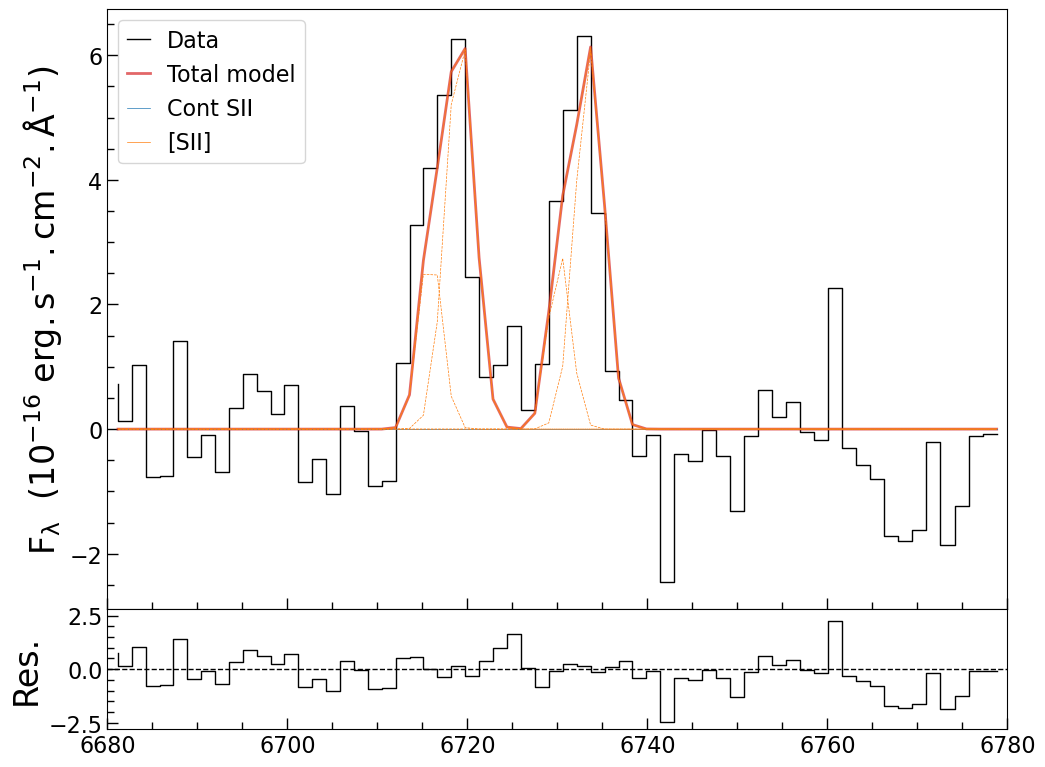

<PowerLaw1D(amplitude=0., x_0=6730., alpha=0., name='Cont SII')>
<Line_MultiGauss_doublet(amp_c0=6.41693791, amp_c1=6.07773992, dv_c=125.12890228, sigma_c=70.90472669, wavec0=6716.44, wavec1=6730.81, amp_w0=0.46791561, dv_w0=-149.63736025, sigma_w0=55.69058101, name='[SII]')>


In [9]:
window = [6680, 6780]
fltr = (wave_rest > window[0]) & (wave_rest < window[1])
wave_sii = wave_rest[fltr]
flux_sii = flux_lines[fltr]
ferr_sii = ferr_dered[fltr]

cont = models.PowerLaw1D(amplitude=0, x_0=6730., alpha=0, fixed=dict(x_0=True, alpha=True, amplitude=True), name='Cont SII')
#ns2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=9.04026453, amp_c1=8.2239653, dv_c=191.91601979, sigma_c=103.59627753,
#                                    wavec0=wave_dict['SII_6716'], wavec1=wave_dict['SII_6730'], name='[SII]')
ns2 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=6.12614425, amp_c1=5.85356985, dv_c=93.05894619, sigma_c=105.07513204, 
                                    amp_w0=0.1, dv_w0=0, sigma_w0=200,
                                    wavec0=wavec_sii_6716, wavec1=wavec_sii_6731, name='[SII]')
                                    

m_init = cont + ns2

fitter = fitting.LevMarLSQFitter()
m_fit_sii = fitter(m_init, wave_sii, flux_sii, maxiter=10000)

ax, axr = sagan.plot.plot_fit(wave_sii, flux_sii, m_fit_sii)
#ax, axr = sagan.plot.plot_fit(wave_use, flux_res, m_init_hb, weight=weight_lines)
#ax.axvspan(xmin=6558, xmax=6566, alpha=0.5, color='C3')
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-16} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.set_xlim(window[0], window[1])
axr.set_ylim([-2.8, 2.8])
plt.show()

for m in m_fit_sii:
    print(m.__repr__())

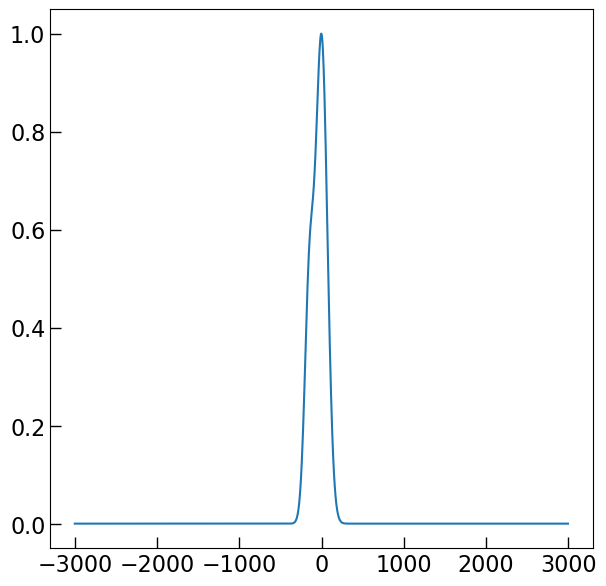

In [10]:
# Generate the narrow line template
ls_km = sagan.constants.ls_km

velc_temp = np.arange(-3e3, 3e3, 5)
wave_temp = (1 + velc_temp / ls_km) * wavec_sii_6716
#m_temp = sagan.Line_MultiGauss(n_components=1, amp_c=1, dv_c=0, sigma_c=m_fit_sii['[SII]'].sigma_c, wavec=wavec_sii_6716)
m_temp = sagan.Line_MultiGauss(n_components=2, amp_c=1, dv_c=0, sigma_c=m_fit_sii['[SII]'].sigma_c, 
                               amp_w0=m_fit_sii['[SII]'].amp_w0, dv_w0=m_fit_sii['[SII]'].dv_w0, sigma_w0=m_fit_sii['[SII]'].sigma_w0,
                               wavec=wavec_sii_6716)
flux_temp = m_temp(wave_temp)
flux_temp /= np.max(flux_temp)
temp_data = np.array([velc_temp, flux_temp]).T
np.savetxt('analysis/J0006-0920_sii.txt', temp_data, fmt='%5e')

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(velc_temp, flux_temp)
plt.show()

### Fit the H⍺ complex

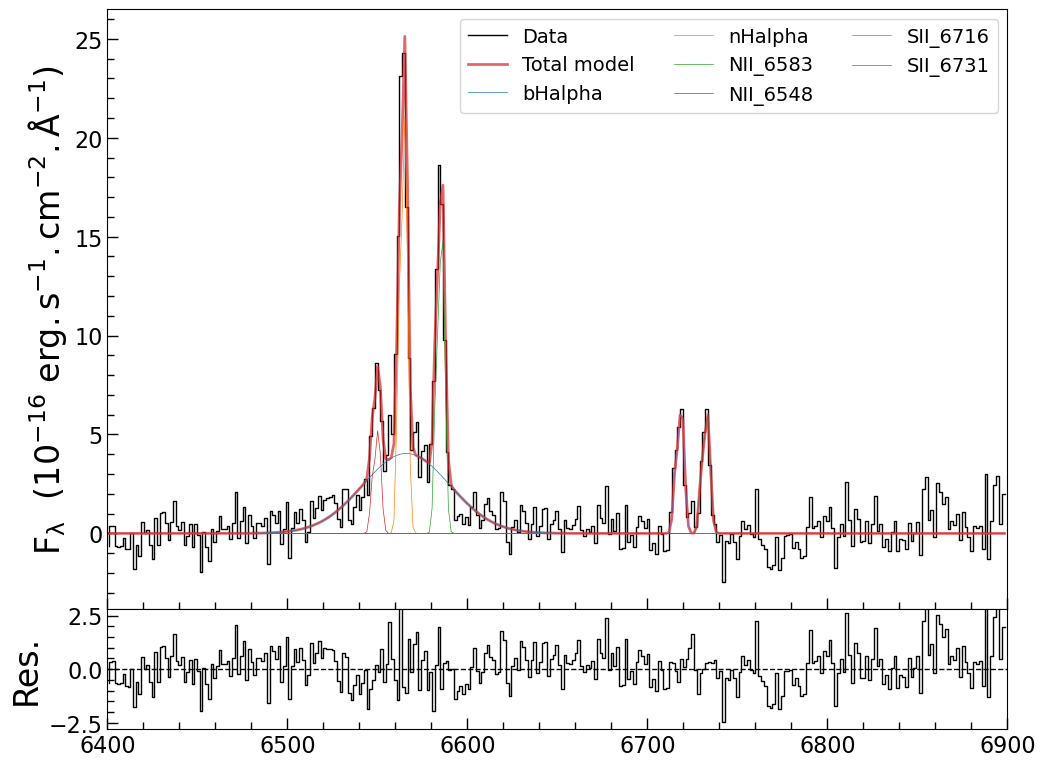

<Line_MultiGauss(amp_c=4.03985246, dv_c=150.3266002, sigma_c=1102.08439907, wavec=6562.819, name='bHalpha')>
<Line_template(amplitude=21.09181541, dv=116.34361553, wavec=6562.819, name='nHalpha')>
<Line_template(amplitude=15.62818397, dv=116.34361553, wavec=6583.46, name='NII_6583')>
<Line_template(amplitude=5.27979188, dv=116.34361553, wavec=6548.05, name='NII_6548')>
<Line_template(amplitude=6.5011103, dv=116.34361553, wavec=6716.44, name='SII_6716')>
<Line_template(amplitude=6.13486071, dv=116.34361553, wavec=6730.81, name='SII_6731')>


In [33]:
# Read the templates
#temp_sii = np.loadtxt('results/J0006-0920_sii.txt')  # If we want to skip the above SII fitting step
#velc_temp = temp_sii[:, 0]
#flux_temp = temp_sii[:, 1]

window = [6400, 6900]
fltr = (wave_rest > window[0]) & (wave_rest < window[1])
wave_ha = wave_rest[fltr]
flux_ha = flux_lines[fltr]
ferr_ha = ferr_dered[fltr]

bha = sagan.Line_MultiGauss(n_components=1, amp_c=4.03952323, dv_c=150.30995833, sigma_c=1102.23008001,
                            wavec=wavec_ha, name='bHalpha')
nha = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=16.99272669, dv=86.18868006, 
                          wavec=wavec_ha, name='nHalpha')
nn2 = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=16.55604126, dv=0, 
                          wavec=wavec_nii_6583, name='NII_6583') +\
      sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=5.59325718, dv=0, 
                         wavec=wavec_nii_6548, name='NII_6548')
ns2 = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=5.23636479, dv=0, 
                          wavec=wavec_sii_6716, name='SII_6716') +\
      sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=5.65680966, dv=0, 
                         wavec=wavec_sii_6731, name='SII_6731')

m_init = bha + nha + nn2 + ns2

# Tie the parameters
for ln in ['NII_6583', 'NII_6548', 'SII_6716', 'SII_6731']:
    m_init[ln].dv.tied = sagan.tie_template_dv('nHalpha')

m_init['NII_6548'].amplitude.tied = sagan.tie_template_amplitude('NII_6583', ratio=2.96)

fitter = fitting.LevMarLSQFitter()
m_fit_ha = fitter(m_init, wave_ha, flux_ha, maxiter=10000)

ax, axr = sagan.plot.plot_fit(wave_ha, flux_ha, m_fit_ha)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-16} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.set_xlim(window[0], window[1])
ax.legend(fontsize=14, ncols=3, loc='upper right')
axr.set_ylim([-2.8, 2.8])
plt.show()

for m in m_fit_ha:
    print(m.__repr__())

### Add the Hβ complex

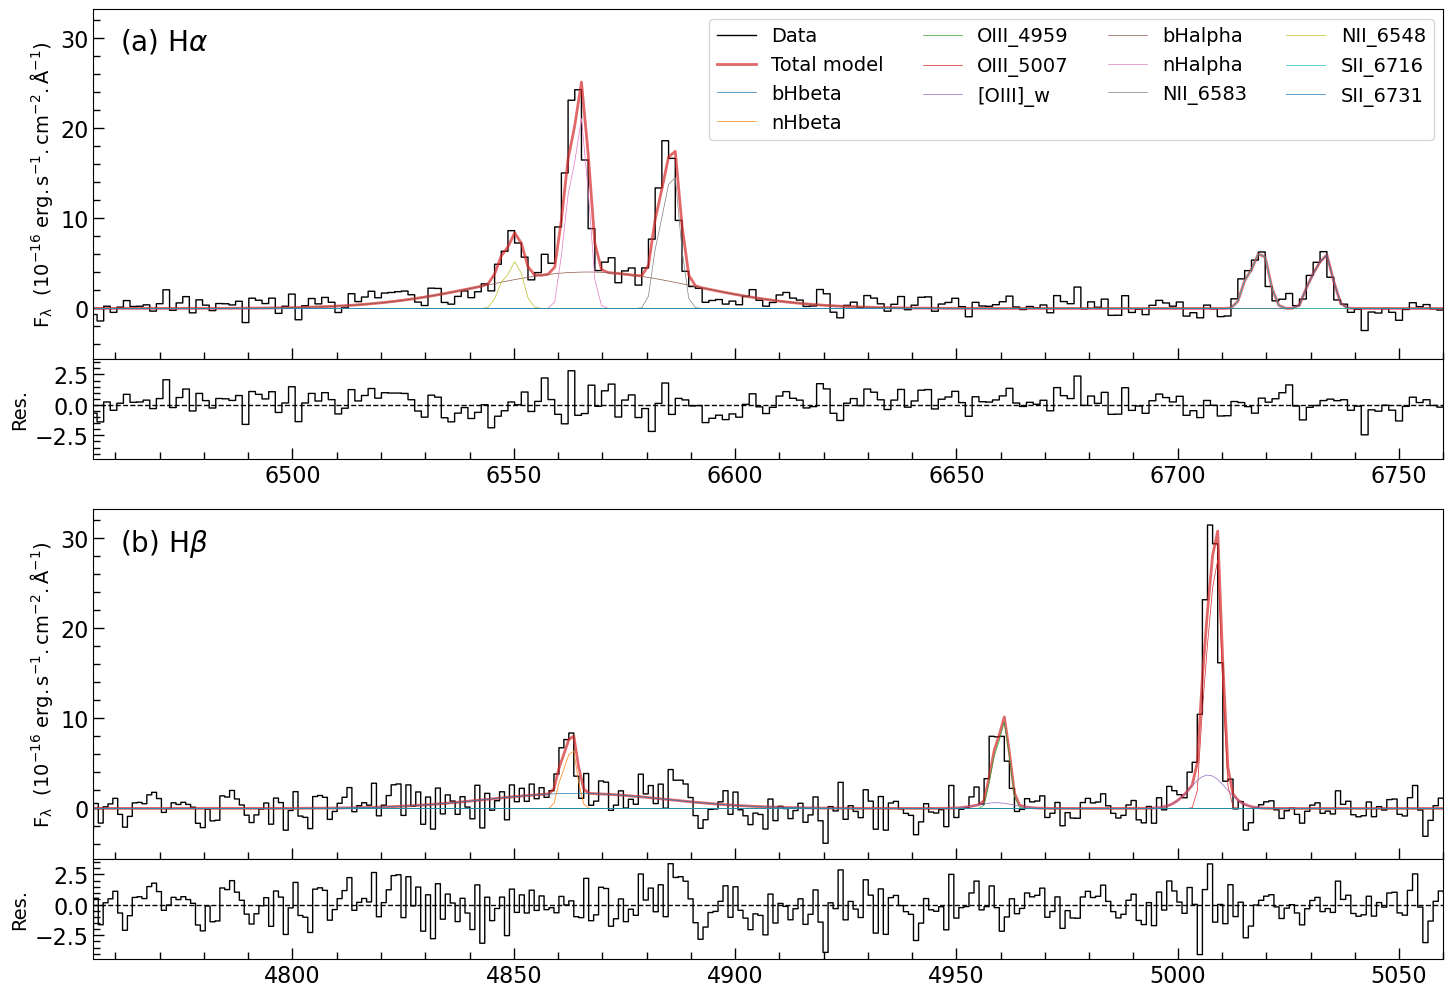

<Line_MultiGauss(amp_c=1.67169788, dv_c=177.85037128, sigma_c=1239.90496734, wavec=4861.333, name='bHbeta')>
<Line_template(amplitude=6.78317401, dv=113.88145988, wavec=4861.333, name='nHbeta')>
<Line_template(amplitude=9.61649638, dv=113.88145988, wavec=4958.911, name='OIII_4959')>
<Line_template(amplitude=28.65715922, dv=113.88145988, wavec=5006.843, name='OIII_5007')>
<Line_MultiGauss_doublet(amp_c0=0.63582601, amp_c1=3.713902, dv_c=0.21336443, sigma_c=242.02847587, wavec0=4958.911, wavec1=5006.843, name='[OIII]_w')>
<Line_MultiGauss(amp_c=4.04166984, dv_c=177.85037128, sigma_c=1103.31354672, wavec=6562.819, name='bHalpha')>
<Line_template(amplitude=21.10791855, dv=113.88145988, wavec=6562.819, name='nHalpha')>
<Line_template(amplitude=15.56294697, dv=113.88145988, wavec=6583.46, name='NII_6583')>
<Line_template(amplitude=5.25775236, dv=113.88145988, wavec=6548.05, name='NII_6548')>
<Line_template(amplitude=6.49380348, dv=113.88145988, wavec=6716.44, name='SII_6716')>
<Line_template

In [34]:
window_list = [[4700, 5100], [6400, 6900]]
fltr = np.zeros_like(wave_rest, dtype=bool)
for window in window_list:
    fltr |= (wave_rest > window[0]) & (wave_rest < window[1])
wave_hb = wave_rest[fltr]
flux_hb = flux_lines[fltr]
ferr_hb = ferr_dered[fltr]

#cont = sagan.WindowedPowerLaw1D(amplitude=20.31459814, x_0=6730., alpha=0.50340581, x_min=window_list[0][0], x_max=window_list[1][1], name='Cont Hb')
bhb = sagan.Line_MultiGauss(n_components=1, amp_c=3.29861897, dv_c=98.83475277, sigma_c=1272.70115266,
                            wavec=wavec_hb, name='bHbeta')
nhb = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=16.99272669, dv=86.18868006, 
                          wavec=wavec_hb, name='nHbeta')
no3 = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=16.55604126, dv=0, 
                          wavec=wavec_oiii_4959, name='OIII_4959') +\
      sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=5.59325718, dv=0, 
                         wavec=wavec_oiii_5007, name='OIII_5007')
no3_w = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=3.0, amp_c1=3.0/2.98, dv_c=0, sigma_c=300,
                                     wavec0=wavec_oiii_4959, wavec1=wavec_oiii_5007, name='[OIII]_w')

m_init = bhb + nhb + no3 + no3_w + m_fit_ha

# Tie the parameters
for ln in ['nHbeta', 'OIII_4959', 'OIII_5007']:
    m_init[ln].dv.tied = sagan.tie_template_dv('nHalpha')

m_init['OIII_4959'].amplitude.tied = sagan.tie_template_amplitude('OIII_5007', ratio=2.98)
m_init['[OIII]_w'].dv_c.tied = sagan.tie_MultiGauss_doublet_ratio('[OIII]_w', ratio=2.98)
m_init['bHbeta'].dv_c.tied = sagan.tie_MultiGauss_dv_c('bHalpha')

fitter = fitting.LevMarLSQFitter()
m_fit_hb = fitter(m_init, wave_hb, flux_hb, maxiter=10000)

#fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig = plt.figure(figsize=(15, 10))
ax00 = fig.add_axes([0.05, 0.65, 0.9, 0.35])
ax01 = fig.add_axes([0.05, 0.55, 0.9, 0.1])
ax10 = fig.add_axes([0.05, 0.15, 0.9, 0.35])
ax11 = fig.add_axes([0.05, 0.05, 0.9, 0.1])

ax, axr = sagan.plot.plot_fit(wave_hb, flux_hb, m_fit_hb, ax=ax00, axr=ax01)
ax.set_xlim([6455, 6760])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-16} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=14)
ax.legend(loc='upper right', fontsize=14, ncols=4)
ax01.set_ylabel('Res.', fontsize=14)
ax00.text(0.02, 0.95, r'(a) H$\alpha$', transform=ax00.transAxes, fontsize=20, va='top', ha='left')

ax, axr = sagan.plot.plot_fit(wave_hb, flux_hb, m_fit_hb, ax=ax10, axr=ax11)
ax.set_xlim([4755, 5060])
ax.set_xlabel(r'Wavelength (Å)', fontsize=24)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-16} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=14)
ax.legend_.remove()
ax11.set_ylabel('Res.', fontsize=14)
ax10.text(0.02, 0.95, r'(b) H$\beta$', transform=ax10.transAxes, fontsize=20, va='top', ha='left')
plt.show()

for m in m_fit_hb:
    print(m.__repr__())


### Calculate the physical parameters

In [35]:
def integrate_line_flux(m_fit, line_name, wave_obs, scale=1e-17):
    """
    Integrate the line flux from the fitted model.

    Parameters:
    m_fit : astropy.modeling.Model
        The fitted model containing the emission line.
    line_name : str
        The name of the emission line to integrate.
    wave_obs : array-like
        Very important! We should use the observed wavelength array.
    scale : float, optional
        The scale factor to convert the flux units, default is 1e-17 erg/s/cm^2/Å.

    Returns:
    line_flux : float
        The integrated line flux in erg/s/cm^2.
    """
    flux = m_fit[line_name](wave_obs) * scale
    line_flux = np.trapz(flux, wave_obs)    
    return line_flux

def cal_fwhm(m_fit, line_name, vlim=10000):
    """
    Calculate the FWHM of the emission line from the fitted model. 
    This function allows for complex line profiles.

    Parameters:
    m_fit : astropy.modeling.Model
        The fitted model containing the emission line.
    line_name : str
        The name of the emission line to calculate FWHM.

    Returns:
    fwhm : float
        The FWHM of the emission line in km/s.
    """
    velc = np.linspace(-vlim, vlim, 10000)
    wave = (1 + velc / ls_km) * m_fit[line_name].wavec
    flux = m_fit[line_name](wave)
    half_max = np.max(flux) / 2
    indices = np.where(flux >= half_max)[0]
    v1 = velc[indices[0]]
    v2 = velc[indices[-1]]
    fwhm = v2 - v1
    return fwhm

flux_hb = integrate_line_flux(m_fit_hb, 'bHbeta', wave_obs)
flux_ha = integrate_line_flux(m_fit_hb, 'bHalpha', wave_obs)
flux_o3 = integrate_line_flux(m_fit_hb, 'OIII_5007', wave_obs)
flux_n2 = integrate_line_flux(m_fit_hb, 'NII_6583', wave_obs)
flux_s2 = integrate_line_flux(m_fit_hb, 'SII_6716', wave_obs) + integrate_line_flux(m_fit_hb, 'SII_6731', wave_obs)

fwhm_ha = cal_fwhm(m_fit_hb, 'bHalpha')
fwhm_hb = cal_fwhm(m_fit_hb, 'bHbeta')
fwhm_narrow = cal_fwhm(m_fit_hb, 'OIII_5007')

# Calculate the BH mass
logMbh = np.log10((fwhm_hb/ 1000)**2 * (nuLnu / 1e44)**0.533) + 6.91  # Equation (2) of Liu et al. (2019, ApJS, 243, 21)

/var/folders/x7/ww3bm0kx1mq7v6r3dk8mccw80000gn/T/ipykernel_9761/2201991639.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  line_flux = np.trapz(flux, wave_obs)


## Analyze the physical properties of this target

### The BPT diagram
* Read this [Annual Review for Astronomy and Astrophysics paper](https://scixplorer.org/abs/2019ARA&A..57..511K/abstract) to learn more

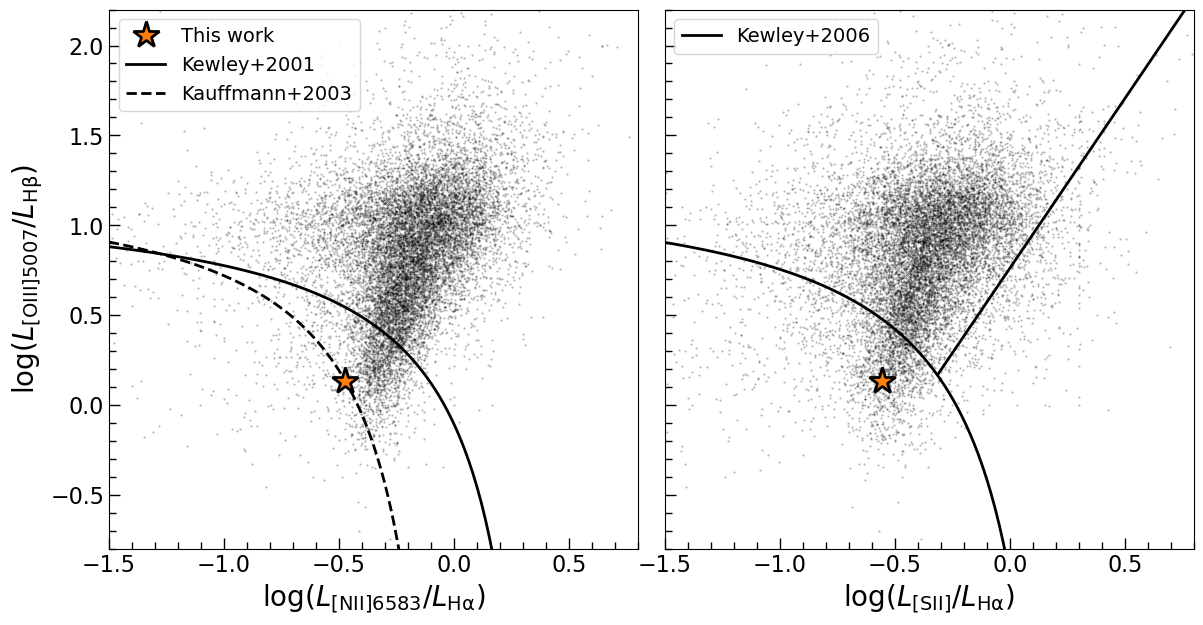

In [36]:
from astropy.table import Table

tb = Table.read('tabs/Liu2019.fits', format='fits')

logLha_l19 = tb['logNHa']
logLhb_l19 = tb['logNHb']
logLn2_l19 = tb['log6583']
logLo3_l19 = tb['log5007']
logLs2_l19 = np.log10(10**tb['log6716'] + 10**tb['log6731'])

fwhm_ha_l19 = tb['FWHMBHa']
fwhm_hb_l19 = tb['FWHMBHb']

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

ax = axs[0]
x_t = np.log10(flux_n2 / flux_ha)
y_t = np.log10(flux_o3 / flux_hb)
ax.plot(x_t, y_t, ms=20, marker='*', ls='none', color='C1', mec='k', mew=2, label='This work', zorder=5)

x = logLn2_l19 - logLha_l19
y = logLo3_l19 - logLhb_l19
fltr = ((x > -10) & (x < 10)) & ((y > -10) & (y < 10))
ax.plot(x[fltr], y[fltr], ms=1, marker='.', ls='none', color='k', alpha=0.3)

ax.set_xlabel(r'$\log (L_{\rm [NII]6583}/L_{\rm H\alpha})$', fontsize=20)
ax.set_ylabel(r'$\log (L_{\rm [OIII]5007}/L_{\rm H\beta})$', fontsize=20)
ax.set_xlim(-1.5, 0.8)
ax.set_ylim(-0.8, 2.2)
ax.minorticks_on()

ax = axs[1]
x_t = np.log10(flux_s2 / flux_ha)
y_t = np.log10(flux_o3 / flux_hb)
ax.plot(x_t, y_t, ms=20, marker='*', ls='none', color='C1', mec='k', mew=2, zorder=5)

x = logLs2_l19 - logLha_l19
fltr = ((x > -10) & (x < 10)) & ((y > -10) & (y < 10))
ax.plot(x[fltr], y[fltr], ms=1, marker='.', ls='none', color='k', alpha=0.3)
ax.set_xlabel(r'$\log (L_{\rm [SII]}/L_{\rm H\alpha})$', fontsize=20)
ax.minorticks_on()

# Demarcation lines; Kewly et al. (2006)
x1 = np.linspace(-1.5, 0.3, 100)
y1 = 0.61 / (x1 - 0.47) + 1.19
axs[0].plot(x1, y1, ls='-', color='k', lw=2, label='Kewley+2001')

x2 = np.linspace(-1.5, 0.0, 100)
y2 = 0.61 / (x2 - 0.05) + 1.3
axs[0].plot(x2, y2, ls='--', color='k', lw=2, label='Kauffmann+2003')

x3 = np.linspace(-1.5, 0.3, 100)
y3 = 0.72 / (x3 - 0.32) + 1.3
axs[1].plot(x3, y3, ls='-', color='k', lw=2, label='Kewley+2006')

x4 = np.linspace(-0.31, 0.8, 100)
y4 = 1.89 * x4 + 0.76
axs[1].plot(x4, y4, ls='-', color='k', lw=2)

axs[0].legend(loc='upper left', fontsize=14)
axs[1].legend(loc='upper left', fontsize=14)
plt.show()

### Check the black hole mass
* Read this [Annual Review for Astronomy and Astrophysics paper](https://scixplorer.org/abs/2013ARA&A..51..511K/abstract) to learn more

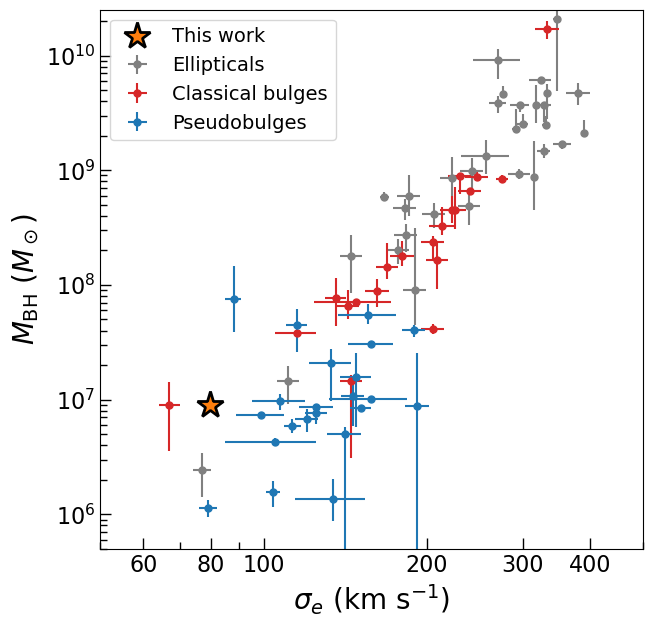

In [15]:
# Table 2 and 3 of Kormendy & Ho (2013, ARA&A, 51, 511)
tb2 = Table.read('tabs/tab2.ipac', format='ascii.ipac')
tb3 = Table.read('tabs/tab3.ipac', format='ascii.ipac')

Mbh_k13 = np.concatenate([tb2['Mbh'], tb3['Mbh']])
lMbh_k13 = np.concatenate([tb2['lMbh'], tb3['lMbh']])
uMbh_k13 = np.concatenate([tb2['uMbh'], tb3['uMbh']])
sigma_k13 = np.ma.concatenate([tb2['sigma'], tb3['sigma']])
esigma_k13 = np.ma.concatenate([tb2['esigma'], tb3['esigma']])
flag = np.concatenate([tb2['flag'], tb3['flag']])
flag_ell = np.concatenate([np.ones_like(tb2['Mbh']), np.zeros_like(tb3['Mbh'])])  # 1 for elliptical, 0 for disk

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(sigma_star, 10**logMbh, ms=20, marker='*', ls='none', color='C1', mec='k', mew=2, label='This work', zorder=5)

fltr = (flag == 1) & (flag_ell == 1)
ax.errorbar(sigma_k13[fltr], Mbh_k13[fltr], xerr=esigma_k13[fltr], yerr=[Mbh_k13[fltr] - lMbh_k13[fltr], uMbh_k13[fltr] - Mbh_k13[fltr]], 
            fmt='o', ms=5, color='gray', label='Ellipticals')
fltr = (flag == 1) & (flag_ell == 0)
ax.errorbar(sigma_k13[fltr], Mbh_k13[fltr], xerr=esigma_k13[fltr], yerr=[Mbh_k13[fltr] - lMbh_k13[fltr], uMbh_k13[fltr] - Mbh_k13[fltr]], 
            fmt='o', ms=5, color='C3', label='Classical bulges')
fltr = (flag == 3)
ax.errorbar(sigma_k13[fltr], Mbh_k13[fltr], xerr=esigma_k13[fltr], yerr=[Mbh_k13[fltr] - lMbh_k13[fltr], uMbh_k13[fltr] - Mbh_k13[fltr]], 
            fmt='o', ms=5, color='C0', label='Pseudobulges')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50, 500])
ax.set_ylim([5e5, 2.5e10])

ax.set_xticks([60, 80, 100, 200, 300, 400])
ax.set_xticklabels([60, 80, 100, 200, 300, 400])
ax.set_xlabel(r'$\sigma_e\ (\rm km\ s^{-1})$', fontsize=20)
ax.set_ylabel(r'$M_{\rm BH}\ (M_\odot)$', fontsize=20)
ax.legend(loc='upper left', fontsize=14)
plt.show()
